In [17]:
# Als je `import clusterizer` typt, dan zoekt Python naar mappen en .py-bestanden met die naam.
# De plekken waar python gaat zoeken staan in de lijst `sys.path`.
# Omdat we nu in SCG-analyse/notebooks zitten, moeten we de bovenliggende map (`SCG-analyse`)
# toevoegen aan de lijst van zoekplekken.
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

# Hiermee wordt de clusterizer module herladen wanneer een bestand ervan verandert
# (handig als je aan de module aan het werken bent).
# Als je dit niet doet, wordt de code (zoals circuit.py, plot.py, etc) alleen geladen wanneer
# je `import clusterizer` typt. 
%load_ext autoreload
%autoreload 2


import clusterizer

import matplotlib.pyplot as plt

# Nodig om een np.datetime64 tijdstip (zoals in de partial_discharges DataFrame) 
# als ascoordinaat te gebruiken.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Hogere DPI voor plotjes (is mooi)
%config InlineBackend.figure_format = 'retina'
# Standaard grootte van plotjes in inches
plt.rcParams['figure.figsize'] = [8, 5]

import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
circnum = clusterizer.globals.available_circuits[5]


circuitje=clusterizer.circuit.MergedCircuit(circnum)
circuitje.build()

<IPython.core.display.Javascript object>


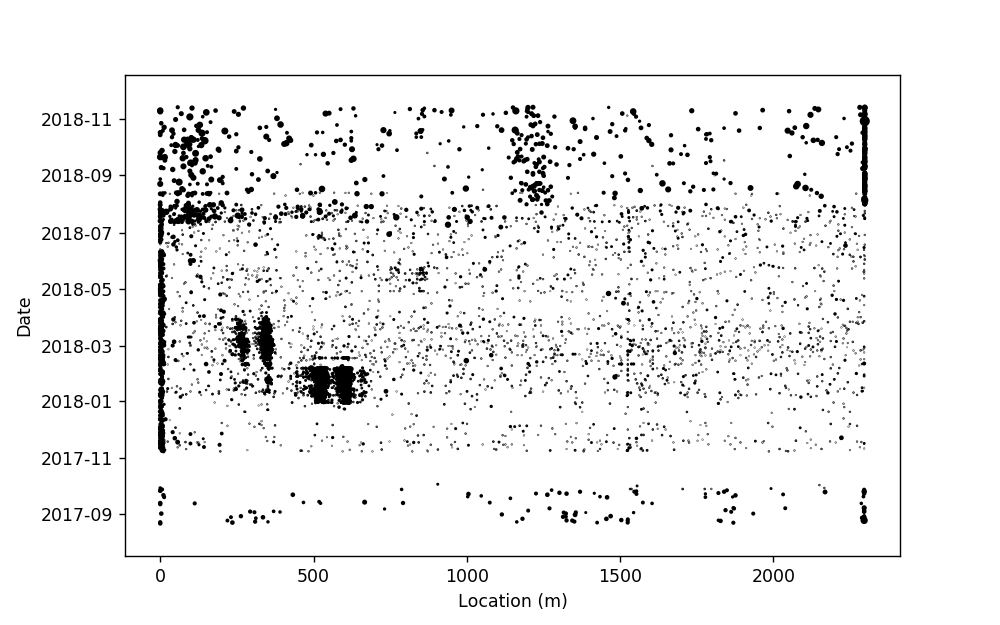

In [228]:
%matplotlib notebook

clusterizer.plot.draw_location_time_scatter(circuitje)
plt.show()

# Klassificeren van periodes waarin PD-gedrag constant is

Dit doen we met een aantal stappen:
1. Discretiseer locatie
1. Identificeer de locaties waarop PD-gedrag nominaal is (laagste 80%)
1. Beschouw nu alle PDs die binnen _die_ locaties vallen, en discretiseer nu juist de tijd.



In [231]:
# --- PARAMETERS ---
bin_size = 4
weigh_charges = False
nominal_circuit_fraction = .70

In [232]:
locations = circuitje.pd["Location in meters (m)"][circuitje.pd_occured]
times = circuitje.pd["Date/time (UTC)"][circuitje.pd_occured]
charges = circuitje.pd["Charge (picocoulomb)"][circuitje.pd_occured]

In [233]:
bins = np.arange(start=0., stop=circuitje.circuitlength+bin_size, step=bin_size)
bin_contents, _ = np.histogram(locations, bins=bins, weights=charges if weigh_charges else None)

In [234]:
nominal_pd_quantile_level = np.sort(bin_contents)[int(nominal_circuit_fraction * len(bin_contents))]

is_below_quantile = bin_contents < nominal_pd_quantile_level

<IPython.core.display.Javascript object>


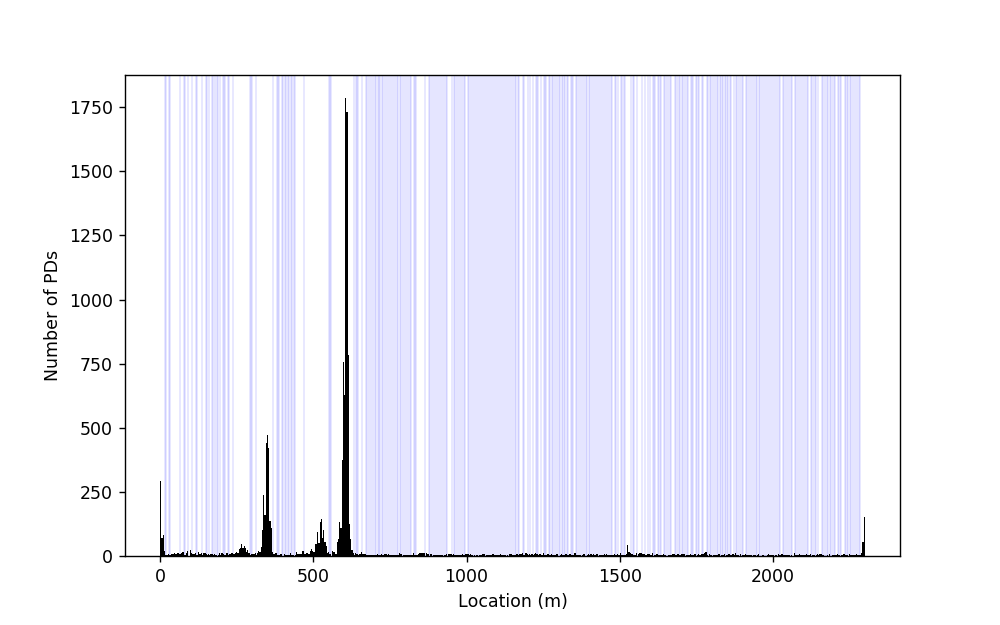

In [235]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_hist(circuitje, ax=ax, bins=bins)
clusterizer.plot.overlay_boolean_series(is_below_quantile, loc=bins[:-1], color="blue", opacity=.1)

Het lijkt zinvol om dit te clusteriseren, maar misschien is dat onnodig:

In [236]:
below_quantile_groups = clusterizer.algorithms.cluster_boolean_series(is_below_quantile)
not_cluster_ranges = [np.array(g)*bin_size for g in below_quantile_groups]
not_cluster_ranges

[array([292, 316]),
 array([ 864, 2288]),
 array([ 64, 240]),
 array([368, 444]),
 array([ 0, 36]),
 array([632, 840])]

<IPython.core.display.Javascript object>


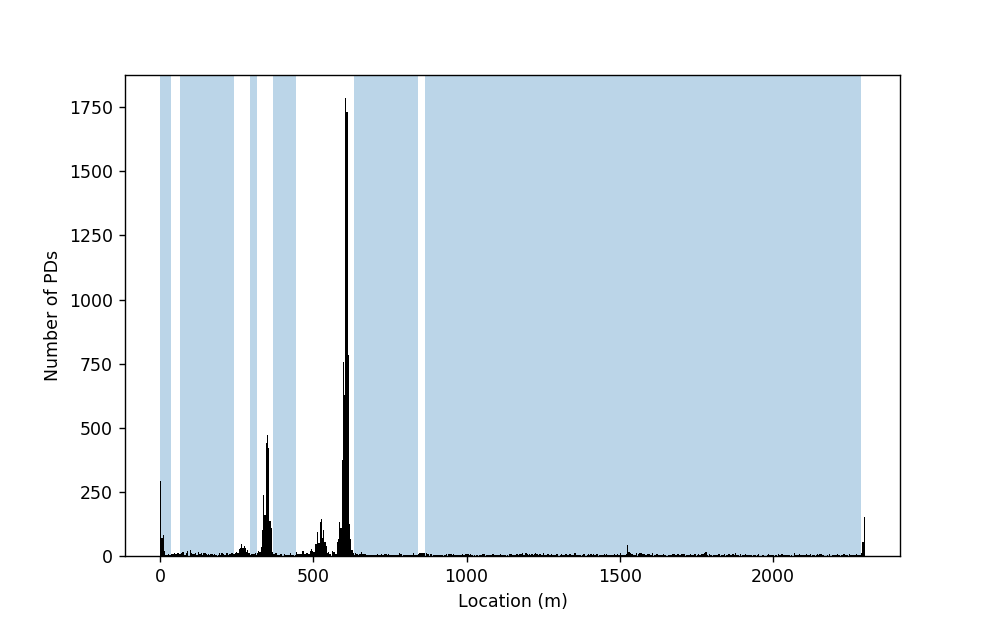

In [237]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_hist(circuitje, ax=ax, bins=bins)

for r in not_cluster_ranges:
    not_a_cluster = clusterizer.cluster.Cluster(location_range=r)
    clusterizer.plot.overlay_cluster(not_a_cluster, ax=ax)

In [238]:
# Dit is niet bedoeld om leesbaar te zijn
import functools

which_inside_location_range = lambda location_range: np.logical_and(location_range[0] < locations.values, locations.values < location_range[1])

#in_a_nuster = functools.reduce(np.logical_or, (are_inside_location_range(locations.values, nr) for nr in not_cluster_ranges))
in_a_nuster = functools.reduce(np.logical_or, map(which_inside_location_range, not_cluster_ranges))

# Maar het geeft:

# in_a_nuster is een np.array van booleans, dat even lang is als het aantal PDs.

# in_a_nuster[i] == True 
#    desda
# de PD nummer i zit in een van de nusters (blauwe gebieden in de vorige plot)

<IPython.core.display.Javascript object>


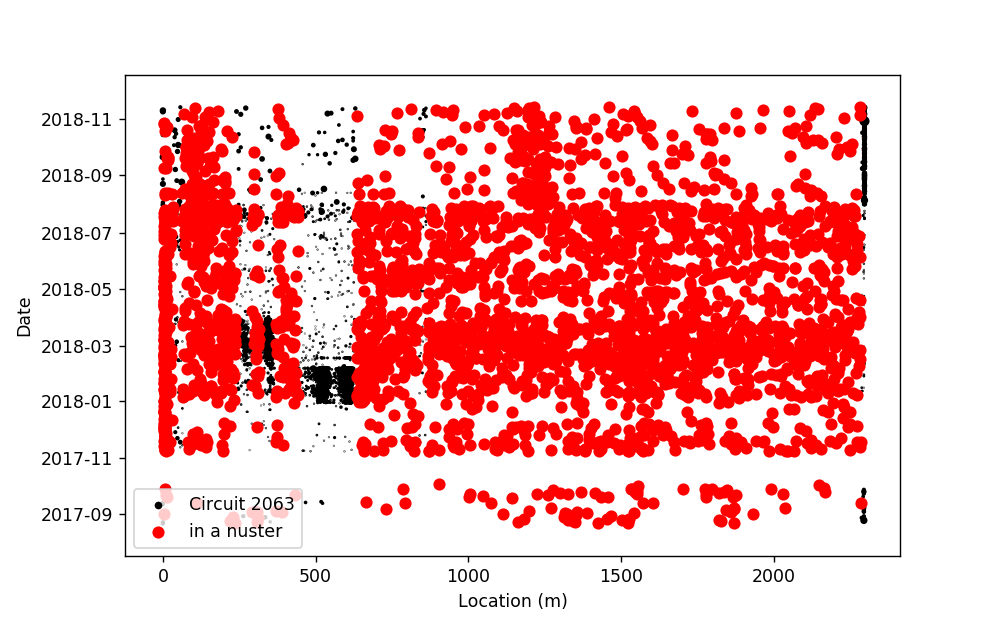

In [239]:
fig, ax = plt.subplots()


nuster_pds = circuitje.pd[circuitje.pd_occured][in_a_nuster]

clusterizer.plot.draw_location_time_scatter(circuitje)
ax.scatter(nuster_pds["Location in meters (m)"], nuster_pds["Date/time (UTC)"], c="red", label="in a nuster")

ax.legend()

In [240]:
locations_in_nuster = locations[in_a_nuster]
times_in_nuster = times[in_a_nuster]
charges_in_nuster = charges[in_a_nuster]

locations_not_in_nuster = locations[~in_a_nuster]
times_not_in_nuster = times[~in_a_nuster]
charges_not_in_nuster = charges[~in_a_nuster]

<IPython.core.display.Javascript object>


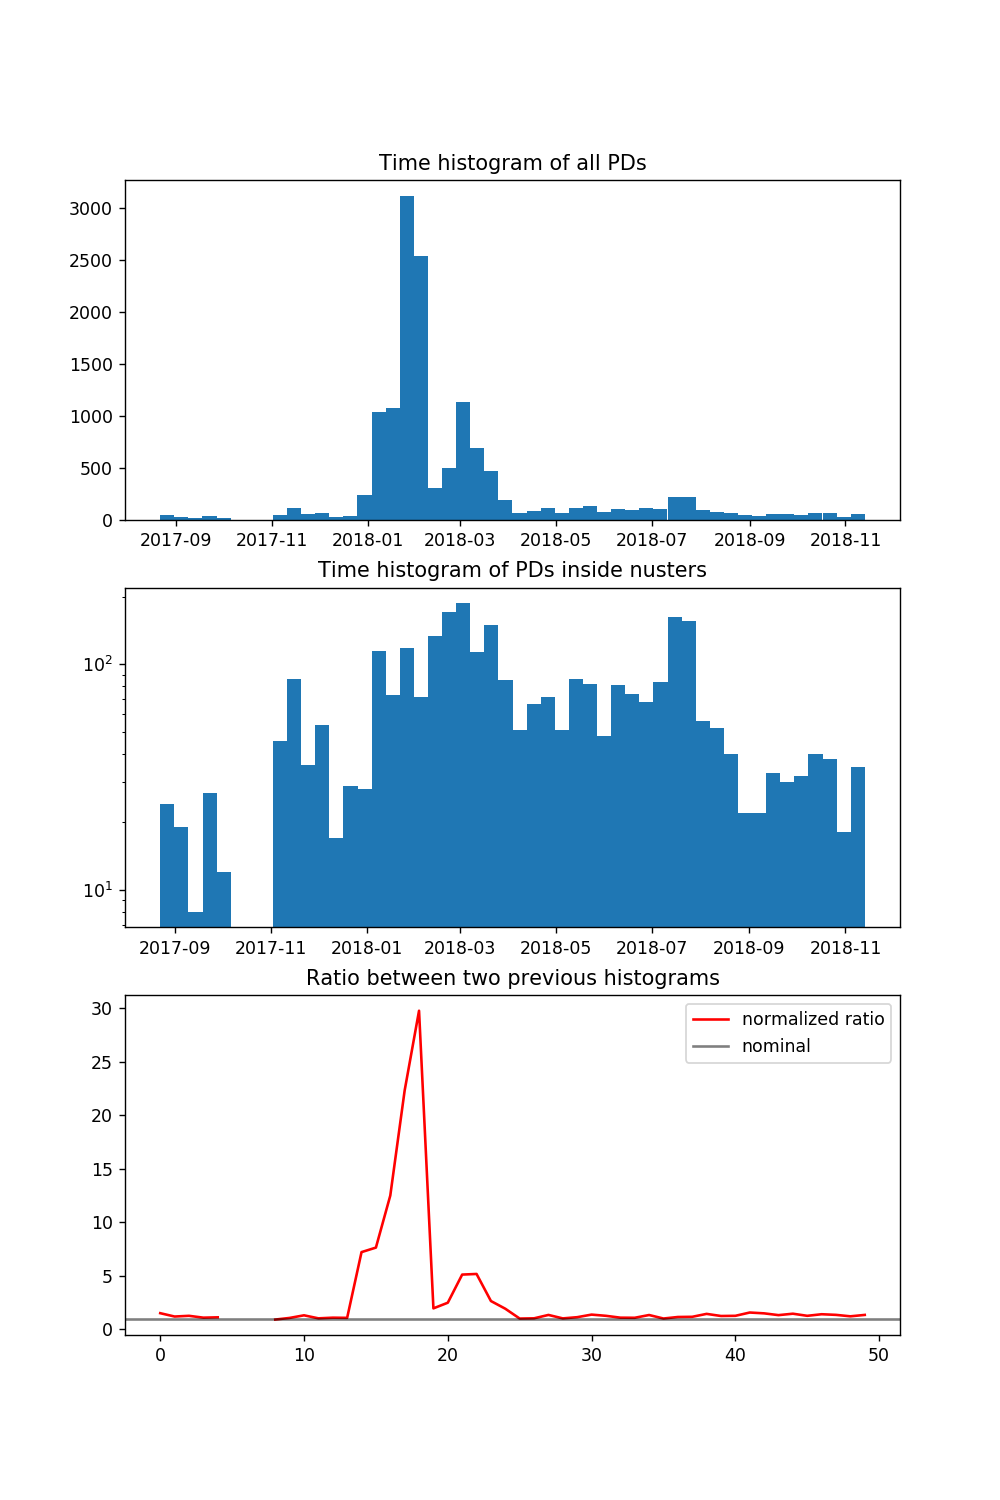

c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [241]:
fig, ax = plt.subplots(3,1,figsize=(8,12))

a,_,_=ax[0].hist(times, bins=50)
ax[0].set_title("Time histogram of all PDs")

b,_,_=ax[1].hist(times_in_nuster, bins=50)
ax[1].set_title("Time histogram of PDs inside nusters")
ax[1].set_yscale("log")

total_nuster_length = sum(b - a for a, b in not_cluster_ranges)
nominal_ratio = circuitje.circuitlength / total_nuster_length

ax[2].plot(a/b/nominal_ratio, c='r', label='normalized ratio')
ax[2].axhline(1, c='0', alpha=.5, label='nominal')
ax[2].set_title("Ratio between two previous histograms")
ax[2].legend()

<IPython.core.display.Javascript object>


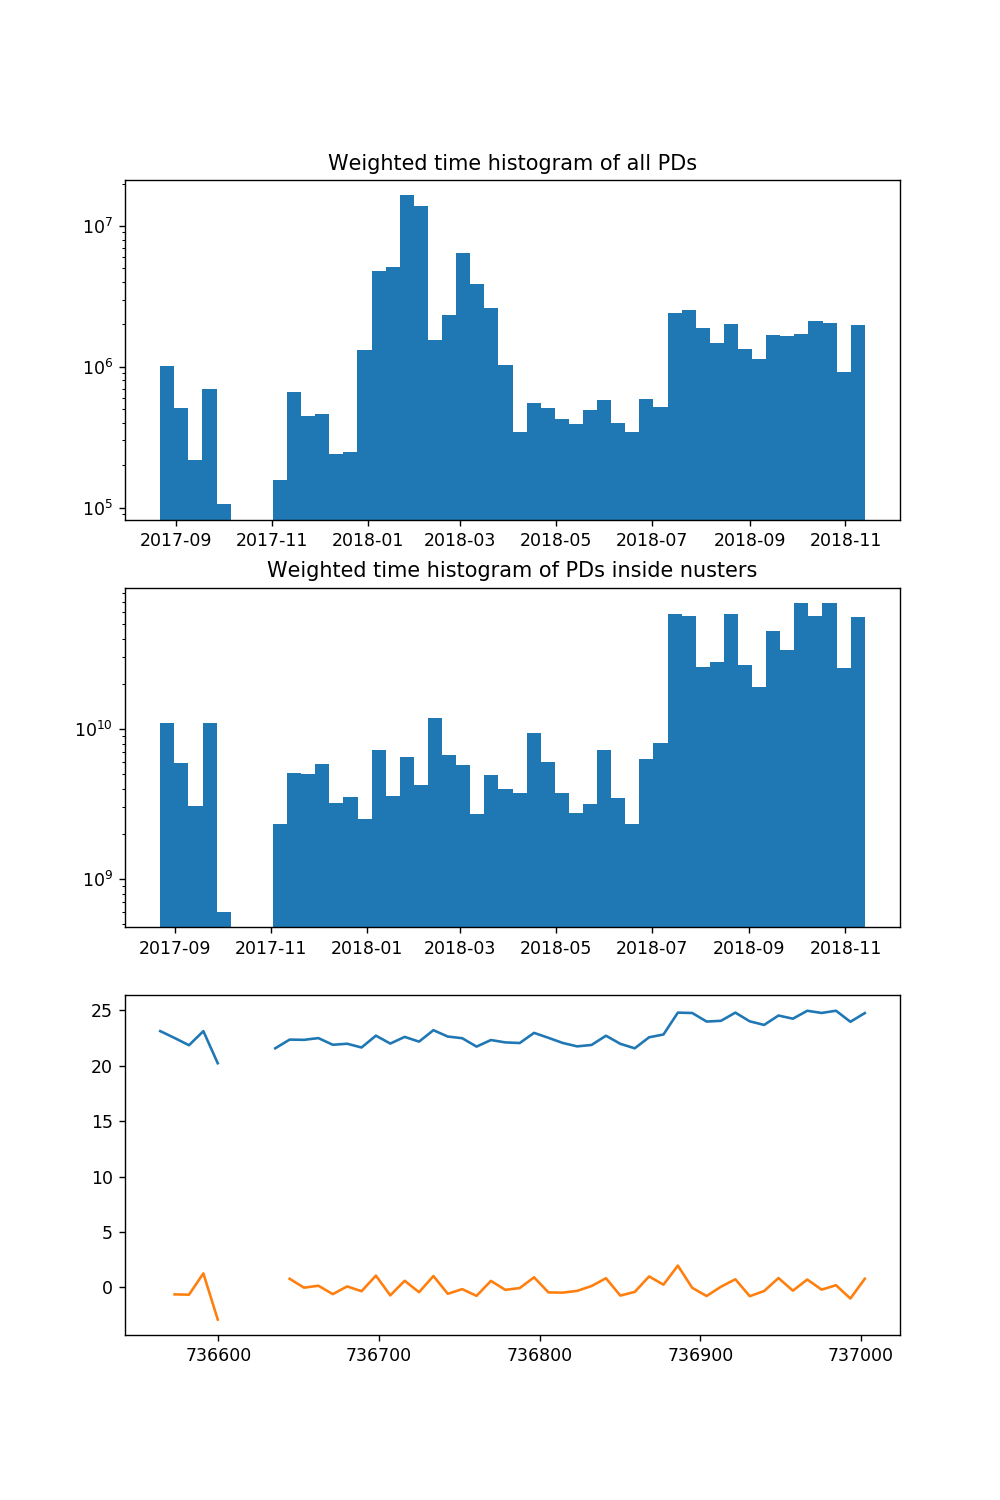

c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in subtract
  del sys.path[0]
c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract
c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


array([False, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [243]:
fig, ax = plt.subplots(3,1,figsize=(8,12))

a,_,_=ax[0].hist(times, weights=charges, bins=50)
ax[0].set_title("Weighted time histogram of all PDs")
ax[0].set_yscale("log")

b,timebins,_=ax[1].hist(times_in_nuster, weights=charges_in_nuster*charges_in_nuster, bins=50)
ax[1].set_title("Weighted time histogram of PDs inside nusters")
ax[1].set_yscale("log")

blog = np.log(b)
ax[2].plot(timebins[:-1], blog)
ax[2].plot(timebins[1:-1], blog[1:] - blog[:-1])

"""
total_nuster_length = sum(b - a for a, b in not_cluster_ranges)
nominal_ratio = circuitje.circuitlength / total_nuster_length

ax[2].plot(a/b/nominal_ratio, c='r', label='normalized ratio')
ax[2].axhline(1, c='0', alpha=.5, label='nominal')
ax[2].set_title("Ratio between two previous histograms")
ax[2].legend()
"""

np.abs(blog[1:] - blog[:-1])>3

<IPython.core.display.Javascript object>


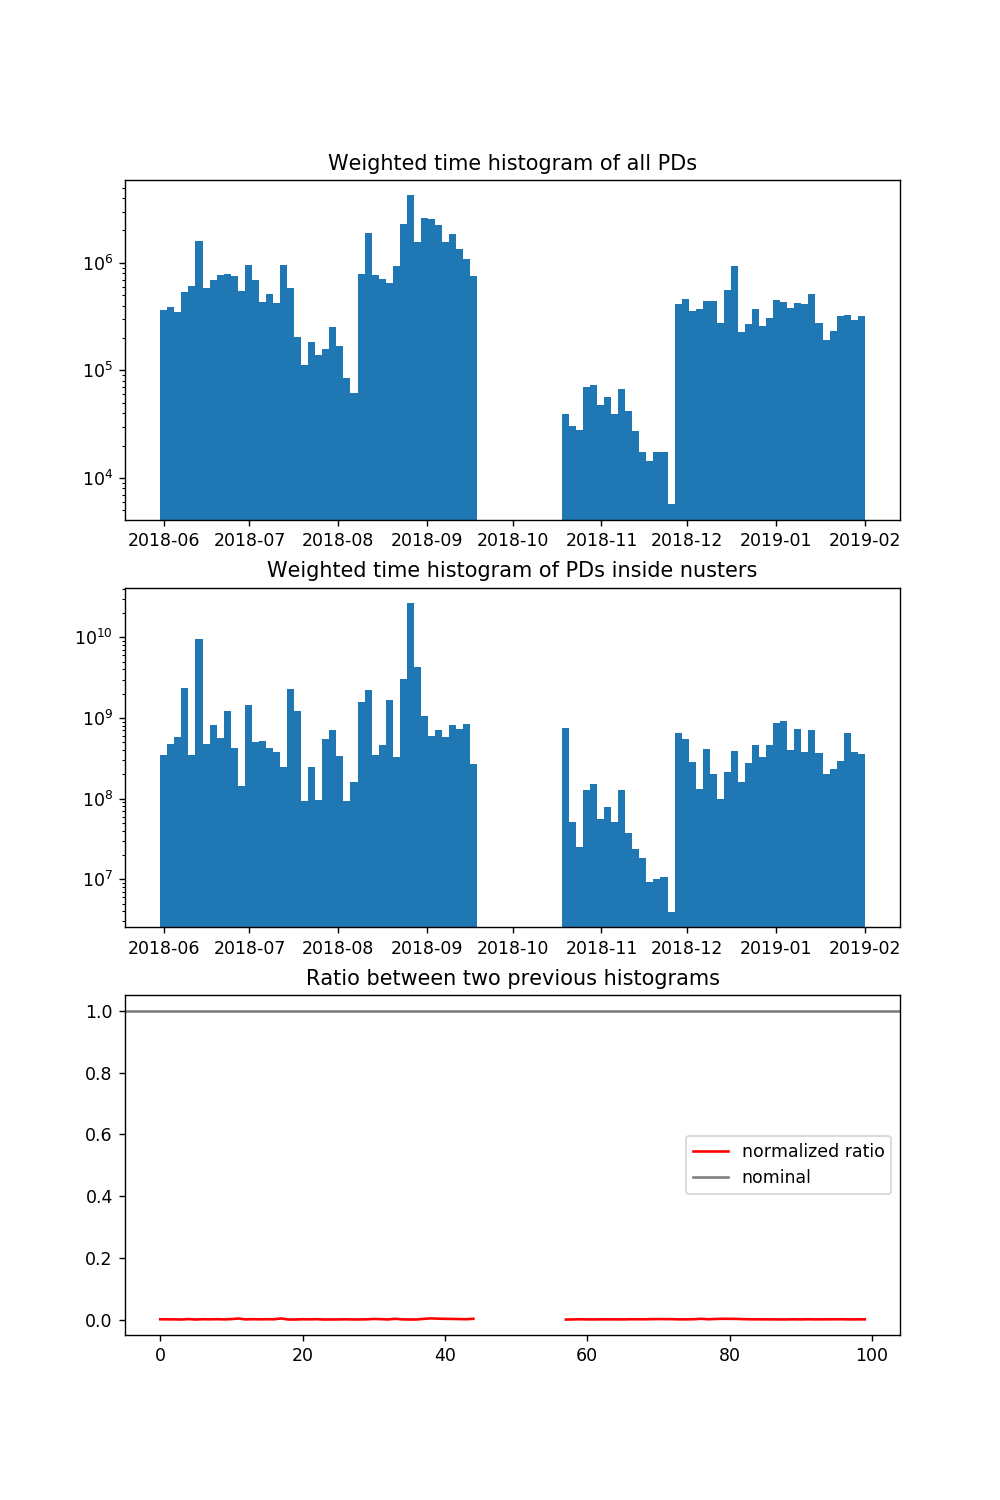

c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [214]:
fig, ax = plt.subplots(3,1,figsize=(8,12))

a,_,_=ax[0].hist(times, weights=charges, bins=100)
ax[0].set_title("Weighted time histogram of all PDs")
ax[0].set_yscale("log")

b,_,_=ax[1].hist(times_in_nuster, weights=charges_in_nuster*charges_in_nuster, bins=100)
ax[1].set_title("Weighted time histogram of PDs inside nusters")
ax[1].set_yscale("log")

total_nuster_length = sum(b - a for a, b in not_cluster_ranges)
nominal_ratio = circuitje.circuitlength / total_nuster_length

ax[2].plot(a/b/nominal_ratio, c='r', label='normalized ratio')
ax[2].axhline(1, c='0', alpha=.5, label='nominal')
ax[2].set_title("Ratio between two previous histograms")
ax[2].legend()

<IPython.core.display.Javascript object>


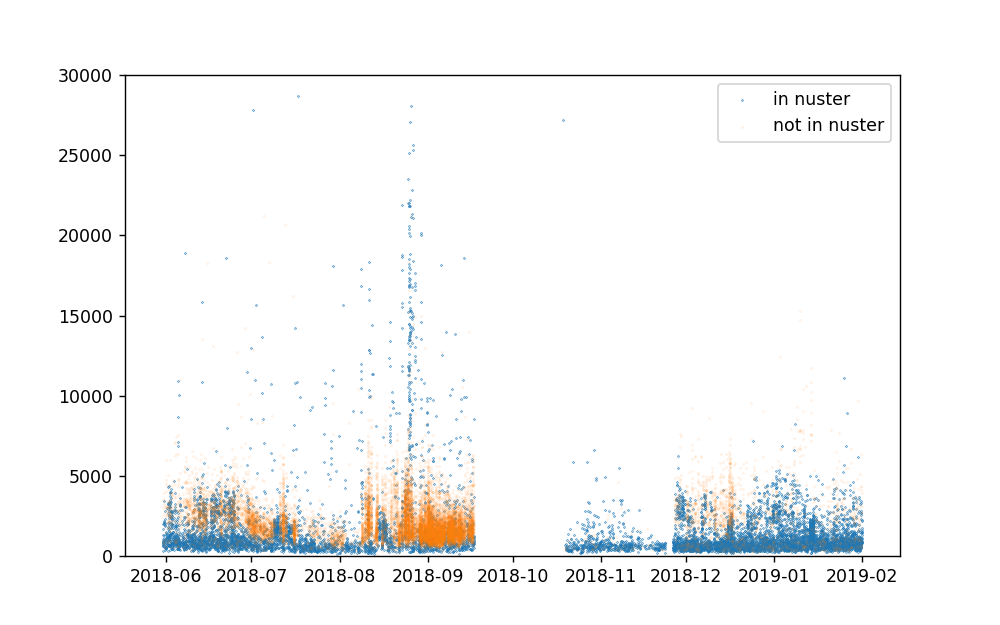

In [210]:
fig, ax = plt.subplots()


ax.scatter(times_in_nuster, charges_in_nuster, s=.1, label="in nuster")
ax.scatter(times_not_in_nuster, charges_not_in_nuster, s=.1, label="not in nuster", alpha=.2)
ax.set_ylim(0,30000)
ax.legend()

<IPython.core.display.Javascript object>


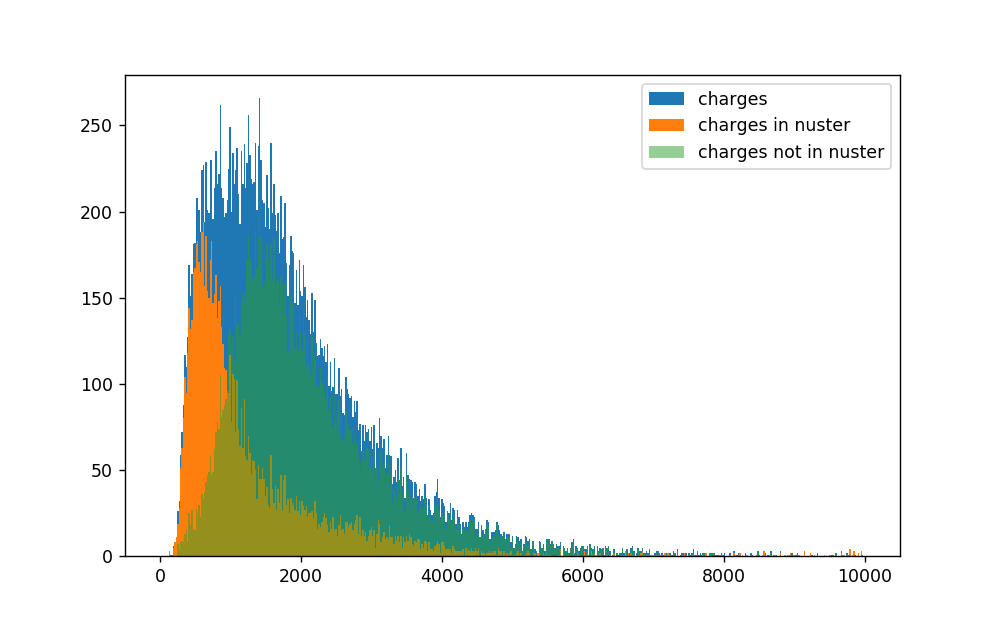

In [205]:
fig, ax = plt.subplots()

b = np.linspace(0,10000,num=500)
ax.hist(charges, bins=b, label="charges")
ax.hist(charges_in_nuster, bins=b, label="charges in nuster")

charges_not_in_nuster = charges[~in_a_nuster]
ax.hist(charges_not_in_nuster, bins=b, label="charges not in nuster", alpha=.5)

ax.legend()

In [102]:
clusters, bins, bin_counts, rate = clusterizer.algorithms.clusterize_poisson(circuitje, bin_size=bin_size, weigh_charges=weigh_charges, nominal_circuit_fraction=nominal_circuit_fraction)

favourite_cluster = list(clusters)[0]

<IPython.core.display.Javascript object>


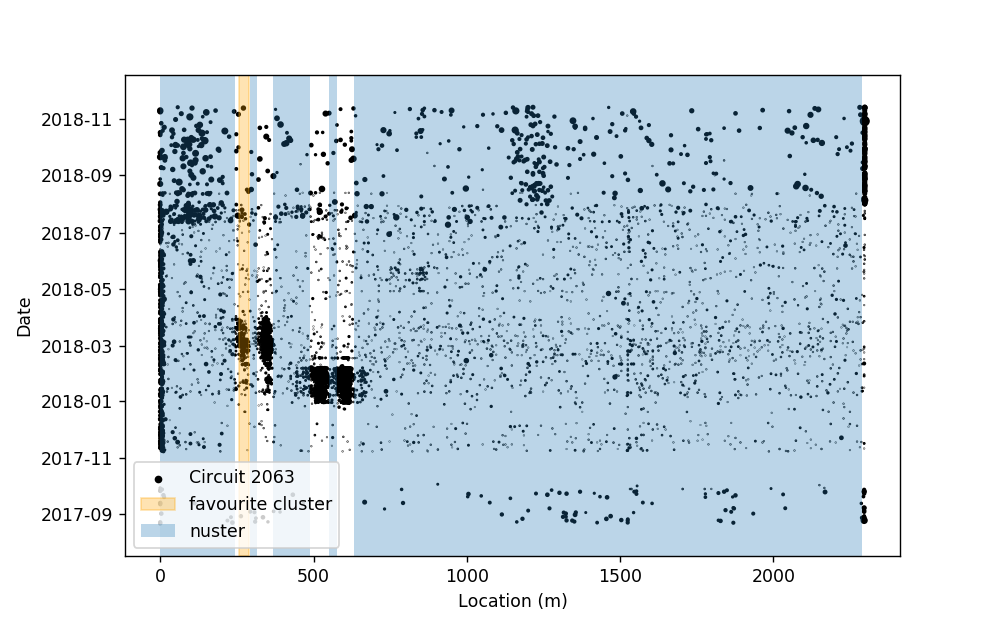

In [129]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)
clusterizer.plot.overlay_cluster(favourite_cluster, ax=ax, color='orange', label="favourite cluster")

for i, r in enumerate(not_cluster_ranges):
    not_a_cluster = clusterizer.cluster.Cluster(location_range=r)
    clusterizer.plot.overlay_cluster(not_a_cluster, ax=ax, label="nuster" if i == 0 else None)

ax.legend()

<IPython.core.display.Javascript object>


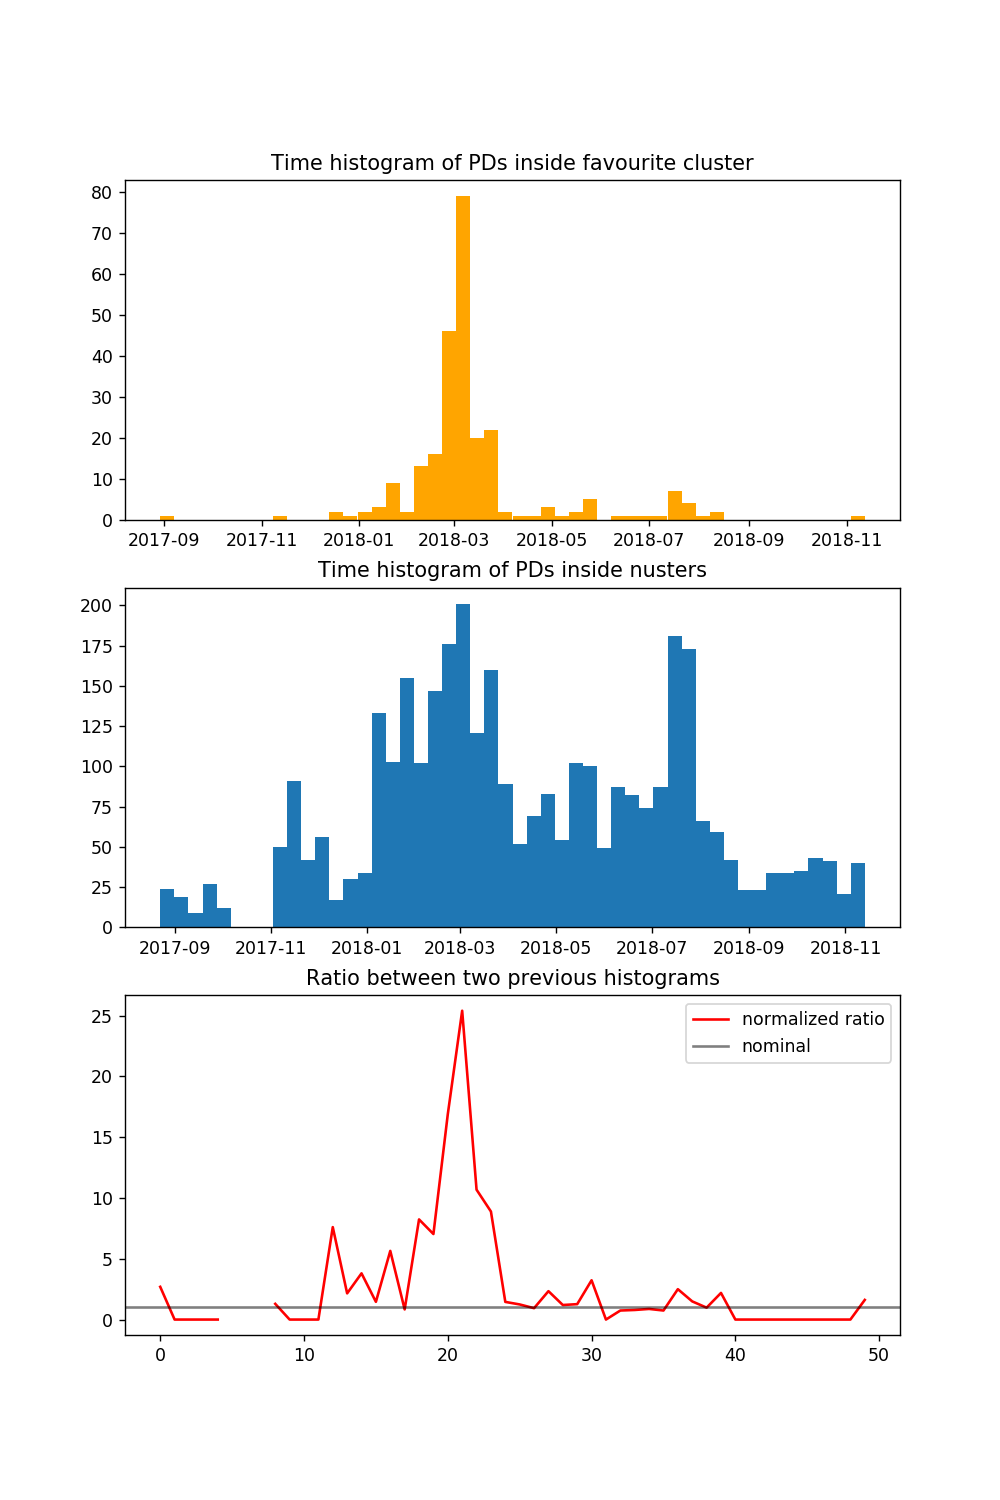

c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [128]:
fig, ax = plt.subplots(3,1,figsize=(8,12))

a,_,_=ax[0].hist(times[which_inside_location_range(favourite_cluster.location_range)], bins=50, color="orange")
ax[0].set_title("Time histogram of PDs inside favourite cluster")

b,_,_=ax[1].hist(times_in_nuster, bins=50)
ax[1].set_title("Time histogram of PDs inside nusters")

total_nuster_length = sum(b - a for a, b in not_cluster_ranges)
cluster_length = favourite_cluster.get_width()
nominal_ratio = cluster_length / total_nuster_length

ax[2].plot(a/b/nominal_ratio, c='r', label='normalized ratio')
ax[2].axhline(1, c='0', alpha=.5, label='nominal')
ax[2].set_title("Ratio between two previous histograms")
ax[2].legend()

c:\dev\py\scg-analyse\venv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 1.0, 'Ratio between two previous histograms')

In [78]:
sum(b-a for a,b in not_cluster_ranges)

2068

In [79]:
circuitje.circuitlength

2299.0

In [124]:
favourite_cluster.get_width()

32